In [ ]:
# try:
#     import transformers
# except:
#     !pip install transformers -qU

# try:
#     import torchmetrics
# except:
#     !pip install torchmetrics -qU

!pip install transformers -qU
!pip install torchmetrics -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 17.5 MB/s eta 0:00:00


In [ ]:
import ast
import warnings
import re
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
from tqdm.notebook import tqdm_notebook
from torchmetrics.functional import bleu_score
warnings.filterwarnings("ignore")

from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_text_data():
    with open("x.txt") as f:
        x_file = f.readlines()

    with open("y.txt") as f:
        y_file = f.readlines()

    x_list = []
    y_list_temp = []

    for x_val, y_val in zip(x_file, y_file):
        x_list.append((x_val.split(", \n")[0]))
        y_list_temp.append((y_val.split(" \n")[0]))

    y_list = []
    for y in y_list_temp:
        x = y
        x = ast.literal_eval(x)
        y_list.append(x)

    x_list_clean = []
    y_list_clean = []

    for x in x_list:
        x = re.sub(r'[^\w\s]', '', x)
        x = x.lower()
        x_list_clean.append(x)

    for y in y_list:
        for i in range(len(y)):
            y[i] = re.sub(r'[^\w\s]', '', y[i])
            y[i] = y[i].lower()
        y_list_clean.append(y)

    return x_list_clean, y_list_clean

_, y_text = load_text_data()

with open("x_bert.txt", 'r') as f:
    x_text = f.readlines()

x_text_cleaned = []
for x in x_text:
    x_text_cleaned.append(x.split('\n')[0])

del x_text
x_text = x_text_cleaned
del x_text_cleaned

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
x_text_marked = [] # list of strings (marked sentences) = '[CLS] + sentence + [SEP]'
x_token_ids_list = [] # list of tensors
x_segment_ids_list = [] # list of tensors

for x in x_text:
    x_marked = "[CLS] " + x + " [SEP]"
    x_text_marked.append(x_marked)
    x_tokenized = tokenizer.tokenize(x_marked) # tokenize the sentence into words
    
    x_token_ids = tokenizer.convert_tokens_to_ids(x_tokenized) # convert the words to their index in the BERT Vocabulary
    x_segment_ids = [1] * len(x_token_ids) # there is only one sentence in the input

    x_token_ids = torch.tensor([x_token_ids]) # convert the list to a pytorch tensor
    x_segment_ids = torch.tensor([x_segment_ids]) # convert the list to a pytorch tensor

    x_token_ids_list.append(x_token_ids)
    x_segment_ids_list.append(x_segment_ids)


y_text_marked = [] # list of strings (marked sentences) = '[CLS] + sentence + [SEP]'
y_token_ids_list = [] # list of tensors
y_segment_ids_list = [] # list of tensors

for y in y_text:
    y_text_single_marked = []
    y_token_ids_single_list = []
    y_segment_ids_single_list = []
    
    for i in range(len(y)):
        y_marked = "[CLS] " + y[i] + " [SEP]"
        y_text_single_marked.append(y_marked)
        y_tokenized = tokenizer.tokenize(y_marked) # tokenize the sentence into words
        
        y_token_ids = tokenizer.convert_tokens_to_ids(y_tokenized) # convert the words to their index in the BERT Vocabulary
        y_segment_ids = [1] * len(y_token_ids) # there is only one sentence in the input

        y_token_ids = torch.tensor([y_token_ids]) # convert the list to a pytorch tensor
        y_segment_ids = torch.tensor([y_segment_ids]) # convert the list to a pytorch tensor

        y_token_ids_single_list.append(y_token_ids)
        y_segment_ids_single_list.append(y_segment_ids)

    y_text_marked.append(y_text_single_marked)
    y_token_ids_list.append(y_token_ids_single_list)
    y_segment_ids_list.append(y_segment_ids_single_list)

In [ ]:
from sklearn.model_selection import train_test_split
train_x_text_marked, val_x_text_marked, train_y_text_marked, val_y_text_marked = train_test_split(x_text_marked, y_text_marked,
                                                                                                  test_size=0.2,
                                                                                                  random_state=42)
test_x_text_marked, val_x_text_marked, test_y_text_marked, val_y_text_marked = train_test_split(train_x_text_marked, train_y_text_marked,
                                                                                                  test_size=0.25,
                                                                                                  random_state=42)
# --------------------------------------------------------------
train_x_token_ids_list, val_x_token_ids_list, train_y_token_ids_list, val_y_token_ids_list = train_test_split(x_token_ids_list, y_token_ids_list,
                                                                                                  test_size=0.2,
                                                                                                  random_state=42)
test_x_token_ids_list, val_x_token_ids_list, test_y_token_ids_list, val_y_token_ids_list = train_test_split(train_x_token_ids_list, train_y_token_ids_list,
                                                                                                  test_size=0.25,
                                                                                                  random_state=42)
# --------------------------------------------------------------
train_x_segment_ids_list, val_x_segment_ids_list, train_y_segment_ids_list, val_y_segment_ids_list = train_test_split(x_segment_ids_list, y_segment_ids_list,
                                                                                                  test_size=0.2,
                                                                                                  random_state=42)
test_x_segment_ids_list, val_x_segment_ids_list, test_y_segment_ids_list, val_y_segment_ids_list = train_test_split(train_x_segment_ids_list, train_y_segment_ids_list,
                                                                                                  test_size=0.25,
                                                                                                  random_state=42)


In [ ]:
train_x_text_marked = x_text_marked[:int(len(x_text_marked)*0.8)]
train_x_token_ids_list = x_token_ids_list[:int(len(x_token_ids_list)*0.8)]
train_x_segment_ids_list = x_segment_ids_list[:int(len(x_segment_ids_list)*0.8)]

train_y_text_marked = y_text_marked[:int(len(y_text_marked)*0.8)]
train_y_token_ids_list = y_token_ids_list[:int(len(y_token_ids_list)*0.8)]
train_y_segment_ids_list = y_segment_ids_list[:int(len(y_segment_ids_list)*0.8)]

val_x_text_marked = x_text_marked[int(len(x_text_marked)*0.8):int(len(x_text_marked)*0.9)]
val_x_token_ids_list = x_token_ids_list[int(len(x_token_ids_list)*0.8):int(len(x_token_ids_list)*0.9)]
val_x_segment_ids_list = x_segment_ids_list[int(len(x_segment_ids_list)*0.8):int(len(x_segment_ids_list)*0.9)]

val_y_text_marked = y_text_marked[int(len(y_text_marked)*0.8):int(len(y_text_marked)*0.9)]
val_y_token_ids_list = y_token_ids_list[int(len(y_token_ids_list)*0.8):int(len(y_token_ids_list)*0.9)]
val_y_segment_ids_list = y_segment_ids_list[int(len(y_segment_ids_list)*0.8):int(len(y_segment_ids_list)*0.9)]

test_x_text_marked = x_text_marked[int(len(x_text_marked)*0.9):]
test_x_token_ids_list = x_token_ids_list[int(len(x_token_ids_list)*0.9):]
test_x_segment_ids_list = x_segment_ids_list[int(len(x_segment_ids_list)*0.9):]

test_y_text_marked = y_text_marked[int(len(y_text_marked)*0.9):]
test_y_token_ids_list = y_token_ids_list[int(len(y_token_ids_list)*0.9):]
test_y_segment_ids_list = y_segment_ids_list[int(len(y_segment_ids_list)*0.9):]

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size=768):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input_token_ids, input_segment_ids, hidden):
        embedded = self.get_bert_embedding(input_token_ids, input_segment_ids).view(1, -1, 768)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def get_bert_embedding(self, input_token_ids, input_segment_ids):
        bert_outputs = self.embedding(input_token_ids, input_segment_ids)

        bert_hidden_states = bert_outputs[2]
        bert_token_embeddings = torch.stack(bert_hidden_states, dim=0)
        bert_token_embeddings = torch.squeeze(bert_token_embeddings, dim=1)
        bert_token_embeddings = bert_token_embeddings.permute(1,0,2)

        # second to last layer embeddings
        bert_tokens_second_to_last  = []

        for token in bert_token_embeddings:
            bert_tokens_second_to_last.append(token[-2])

        bert_tokens_second_to_last = torch.stack(bert_tokens_second_to_last, dim=0)
        
        return bert_tokens_second_to_last
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size=768, output_size=tokenizer.vocab_size):
        super(DecoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_token_ids, input_segment_ids, hidden):
        output = self.get_bert_embedding(input_token_ids, input_segment_ids).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def get_bert_embedding(self, input_token_ids, input_segment_ids):
        bert_outputs = self.embedding(input_token_ids, input_segment_ids)

        bert_hidden_states = bert_outputs[2]
        bert_token_embeddings = torch.stack(bert_hidden_states, dim=0)
        bert_token_embeddings = torch.squeeze(bert_token_embeddings, dim=1)
        bert_token_embeddings = bert_token_embeddings.permute(1,0,2)

        # second to last layer embeddings
        bert_tokens_second_to_last  = []

        for token in bert_token_embeddings:
            bert_tokens_second_to_last.append(token[-2])

        bert_tokens_second_to_last = torch.stack(bert_tokens_second_to_last, dim=0)
        
        return bert_tokens_second_to_last

In [ ]:
encoder = EncoderRNN().to(device)
decoder = DecoderRNN().to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

criterion = nn.NLLLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 

In [ ]:
for param in encoder.embedding.parameters():
    param.requires_grad = False

for param in decoder.embedding.parameters():
    param.requires_grad = False

for param in encoder.embedding.encoder.layer[11].parameters():
    param.requires_grad = True

for param in decoder.embedding.encoder.layer[11].parameters():
    param.requires_grad = True

encoder_total_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
decoder_total_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)

print(f'Encoder total parameters: {encoder_total_params:,}')
print(f'Decoder total parameters: {decoder_total_params:,}')

Encoder total parameters: 10,631,424
Decoder total parameters: 34,102,842


In [ ]:
var1 = train_x_token_ids_list[0][0][1].view(1, -1).to(device) # 1 word token id
var2 = train_x_segment_ids_list[0][0][1].view(1, -1).to(device) # 1 word segment id
out1 = encoder.get_bert_embedding(var1, var2)

print(f'Input Word: {tokenizer.convert_ids_to_tokens(var1.item())}')

print(f'var1.shape = {var1.shape}')
print(f'var2.shape = {var2.shape}')
print(f'Output Embedding shape = {out1.shape}')

encoder_output, encoder_hidden = encoder.forward(var1, var2, encoder.init_hidden())
print(f'encoder_output.shape = {encoder_output.shape}')

decoder_hidden = encoder_hidden
decoder_input_token_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

decoder_output, decoder_hidden = decoder(decoder_input_token_ids, decoder_input_segment_ids, decoder_hidden)

print(f'decoder_output.shape = {decoder_output.shape}')
topv, topi = decoder_output.topk(1)

print(f'Next word (predicted): {tokenizer.convert_ids_to_tokens(topi.item())}')

Input Word: wine
var1.shape = torch.Size([1, 1])
var2.shape = torch.Size([1, 1])
Output Embedding shape = torch.Size([1, 768])
encoder_output.shape = torch.Size([1, 1, 768])
decoder_output.shape = torch.Size([1, 30522])
Next word (predicted): asserted


In [ ]:
EPOCHS = 5
N_TRAIN = 500
N_VAL = 500
train_epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(EPOCHS):
    train_ex_loss_list = []
    val_ex_loss_list = []

    # TRAIN STEP:
    for i in tqdm_notebook(range(N_TRAIN)):
        x_token_ids = train_x_token_ids_list[i].to(device)
        x_segment_ids = train_x_segment_ids_list[i].to(device)

        y_token_ids_list = train_y_token_ids_list[i]
        y_segment_ids_list = train_y_segment_ids_list[i]

        input_length = x_token_ids.size()[1]
        target_length = y_token_ids_list[0].size()[1]
        n_captions = len(y_token_ids_list)

        encoder_hidden = encoder.init_hidden()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(x_token_ids[0][ei].view(1, -1).to(device),
                                                     x_segment_ids[0][ei].view(1, -1).to(device),
                                                     encoder_hidden)

        decoder_hidden = encoder_hidden
        decoder_input_token_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
        decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

        teacher_forcing = True if random.random() < 0.5 else False
        word_loss_list = []
        
# Gradient optimization on each example after accumulating gradients of 1 sentence
        for di in range(target_length):
            if teacher_forcing:
                decoder_output, decoder_hidden = decoder(decoder_input_token_ids,
                                                         decoder_input_segment_ids,
                                                         decoder_hidden)
                decoder_input_token_ids = y_token_ids_list[0][0][di].view(1, -1).to(device)
                decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

            else:
                decoder_output, decoder_hidden = decoder(decoder_input_token_ids.to(device),
                                                         decoder_input_segment_ids.to(device),
                                                         decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input_token_ids = torch.tensor(topi.item(), device=device).view(1, -1)
                decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

            loss = criterion(decoder_output,
                             y_token_ids_list[0][0][di].view(1).to(device))
            word_loss_list.append(loss)

        ex_loss = torch.mean(torch.stack(word_loss_list)) # sentence_loss = ex_loss
        train_ex_loss_list.append(ex_loss)

        ex_loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

    # VAL STEP:
    for i in tqdm_notebook(range(N_VAL)):
        x_token_ids = val_x_token_ids_list[i].to(device)
        x_segment_ids = val_x_segment_ids_list[i].to(device)

        y_token_ids_list = val_y_token_ids_list[i]
        y_segment_ids_list = val_y_segment_ids_list[i]

        input_length = x_token_ids.size()[1]
        target_length = y_token_ids_list[0].size()[1]
        n_captions = len(y_token_ids_list)
        predicted_ids = []

        encoder_hidden = encoder.init_hidden()

        with torch.no_grad():
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(x_token_ids[0][ei].view(1, -1).to(device),
                                                        x_segment_ids[0][ei].view(1, -1).to(device),
                                                        encoder_hidden)

            decoder_hidden = encoder_hidden
            decoder_input_token_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
            decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

            teacher_forcing = False
            word_loss_list = []

            for di in range(target_length):
                if teacher_forcing:
                    decoder_output, decoder_hidden = decoder(decoder_input_token_ids,
                                                            decoder_input_segment_ids,
                                                            decoder_hidden)
                    topv, topi = decoder_output.topk(1)
                    decoder_input_token_ids = y_token_ids_list[0][0][di].view(1, -1).to(device)
                    decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

                else:
                    decoder_output, decoder_hidden = decoder(decoder_input_token_ids.to(device),
                                                            decoder_input_segment_ids.to(device),
                                                            decoder_hidden)
                    topv, topi = decoder_output.topk(1)
                    decoder_input_token_ids = torch.tensor(topi.item(), device=device).view(1, -1)
                    decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

                predicted_ids.append(topi.item())

                loss = criterion(decoder_output,
                                y_token_ids_list[0][0][di].view(1).to(device))
                word_loss_list.append(loss)

            ex_loss = torch.mean(torch.stack(word_loss_list)) # sentence_loss = ex_loss
            val_ex_loss_list.append(ex_loss)


    train_epoch_loss = torch.mean(torch.stack(train_ex_loss_list))
    train_epoch_loss_list.append(train_epoch_loss.item())

    val_epoch_loss = torch.mean(torch.stack(val_ex_loss_list))
    val_epoch_loss_list.append(val_epoch_loss.item())

    input_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x_token_ids))
    target_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(y_token_ids_list[0]))
    predicted_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(predicted_ids))
    
    print(f'EPOCH: {epoch+1} \t train_loss: {train_epoch_loss_list[-1]:.3f} \t val_loss: {val_epoch_loss_list[-1]:.3f}')
    print(f'input: {input_sentence}')
    print(f'target: {target_sentence}')
    print(f'predicted: {predicted_sentence}')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
N_TEST = 500
test_loss_list = []
MAX_LENGTH = 50
results = []

for i in tqdm_notebook(range(N_TEST)):
    x_token_ids = test_x_token_ids_list[i].to(device)
    x_segment_ids = test_x_segment_ids_list[i].to(device)

    y_token_ids_list = test_y_token_ids_list[i]
    y_segment_ids_list = test_y_segment_ids_list[i]

    encoder_hidden = encoder.init_hidden()

    input_length = x_token_ids.size()[1]
    target_length = y_token_ids_list[0].size()[1]

    predicted_ids = []
    word_loss_list = []

    with torch.no_grad():
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(x_token_ids[0][ei].view(1, -1).to(device),
                                                    x_segment_ids[0][ei].view(1, -1).to(device),
                                                    encoder_hidden)
            
        decoder_hidden = encoder_hidden
        decoder_input_token_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
        decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)
        
        for di in range(MAX_LENGTH-1):
            decoder_output, decoder_hidden = decoder(decoder_input_token_ids.to(device),
                                                     decoder_input_segment_ids.to(device),
                                                     decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input_token_ids = torch.tensor(topi.item(), device=device).view(1, -1)
            decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)
            predicted_ids.append(topi.item())

            loss = criterion(decoder_output,
                            y_token_ids_list[0][0][di].view(1).to(device) if di < target_length else torch.tensor(tokenizer.sep_token_id, device=device).view(1))
            word_loss_list.append(loss)

            if topi.item() == tokenizer.sep_token_id:
                break

        if predicted_ids[-1] != tokenizer.sep_token_id:
            predicted_ids.append(tokenizer.sep_token_id)
            
    ex_loss = torch.mean(torch.stack(word_loss_list))
    test_loss_list.append(ex_loss.item())

    input_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x_token_ids.cpu().numpy()[0]))
    target_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(y_token_ids_list[0].cpu().numpy()[0]))
    predicted_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(predicted_ids))

    results.append((input_sentence, target_sentence, predicted_sentence))

    # print(f'input: {input_sentence}')
    # print(f'target: {target_sentence}')
    # print(f'predicted: {predicted_sentence}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
for input, target, pred in results:
    print(f'input: {input}')
    print(f'target: {target}')
    print(f'predicted: {pred}')
    print()

input: [CLS] person 0 10 20 100 cat 60 30 100 100 [SEP]
target: [CLS] the person is holding a treat for the cats [SEP]
predicted: [CLS] a man of a a a a a a a [SEP]

input: [CLS] person 30 70 40 100 person 40 70 50 100 kite 30 60 60 70 kite 50 30 70 40 kite 50 10 60 20 kite 30 70 40 80 kite 30 50 40 50 person 60 70 70 100 kite 40 40 60 60 kite 80 40 80 40 person 80 80 90 100 kite 70 50 80 60 kite 40 20 50 20 kite 20 40 20 40 kite 40 30 40 30 person 80 80 80 100 person 0 70 10 90 kite 70 10 70 10 kite 60 20 60 30 [SEP]
target: [CLS] several colorful kites in the sky by several persons in the ground [SEP]
predicted: [CLS] a man of a a a a a a a [SEP]

input: [CLS] toilet 30 60 60 90 sink 80 60 100 60 [SEP]
target: [CLS] a view of a bathroom that is clean [SEP]
predicted: [CLS] a man of a a a a a a a [SEP]

input: [CLS] person 40 70 40 80 person 90 70 90 80 person 60 70 70 80 kite 30 50 40 60 kite 0 70 10 80 [SEP]
target: [CLS] a group of people flying kites at the beach [SEP]
predicted: 

In [ ]:
from transformers import AutoTokenizer, GPT2Model
import torch

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [ ]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs.input_ids.cpu().numpy()[0]))

'Hello, my dog is cute'

In [ ]:
f'{sum(p.numel() for p in model.parameters() if p.requires_grad):,}'

'124,439,808'

In [ ]:
ENCODER_PATH = 'encoder.pt'
DECODER_PATH = 'decoder.pt'

torch.save({'epoch': epoch,
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': encoder_optimizer.state_dict()
            }, ENCODER_PATH)

torch.save({'epoch': epoch,
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': decoder_optimizer.state_dict()
            }, DECODER_PATH)

In [ ]:
encoder1 = EncoderRNN().to(device)
encoder_optimizer1 = optim.Adam(encoder1.parameters())

encoder1.load_state_dict(encoder_ckpt['model_state_dict'])
encoder_optimizer1.load_state_dict(encoder_ckpt['optimizer_state_dict'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


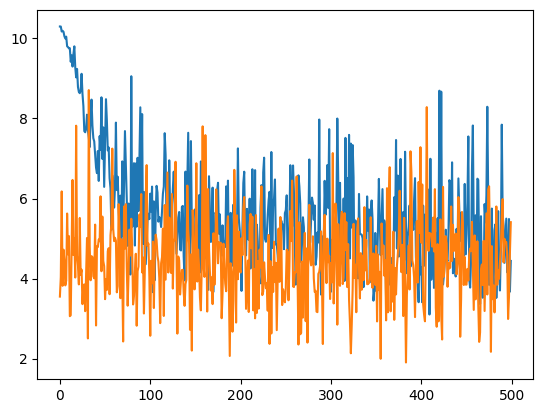

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_loss_list[:500 ])
plt.plot(val_epoch_loss_list)
plt.show()

In [ ]:
from google.colab import files
files.download('encoder.pt')

In [ ]:
predicted_ids = []

for i in range(len(x_token_ids_list[0][0])):
    encoder_output, encoder_hidden = encoder(x_token_ids_list[0][0][i].view(1, 1), x_segment_ids_list[0][0][i].view(1, 1), encoder.init_hidden())

    decoder_hidden = encoder_hidden
    decoder_input_token_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    decoder_input_segment_ids = torch.tensor([[1] * len(decoder_input_token_ids)], device=device)

    decoder_output, decoder_hidden = decoder(decoder_input_token_ids, decoder_input_segment_ids, decoder_hidden)
    topv, topi = decoder_output.topk(1)

    predicted_ids.append(topi.item())

In [ ]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(predicted_ids))

'brood require [unused962]uiluil expulsion require ） fang fanguil require starveduil ）uil requireuiluil expulsion expulsion requireuil fang [unused962] expulsion requireuil ） [unused962] fang require fanguiluil fang require [unused962] ）uiluil require fang ）uiluil require [unused962] fang [unused962] expulsion helps'

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size=768, output_size=768, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.embedding.eval()

        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_token_ids, input_segment_ids, hidden, encoder_outputs):
        embedded = self.get_bert_embedding(input_token_ids, input_segment_ids).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def get_bert_embedding(self, input_token_ids, input_segment_ids):
        with torch.no_grad():
            bert_outputs = self.embedding(input_token_ids, input_segment_ids)

        bert_hidden_states = bert_outputs[2]
        bert_token_embeddings = torch.stack(bert_hidden_states, dim=0)
        bert_token_embeddings = torch.squeeze(bert_token_embeddings, dim=1)
        bert_token_embeddings = bert_token_embeddings.permute(1,0,2)

        # second to last layer embeddings
        bert_tokens_second_to_last  = []

        for token in bert_token_embeddings:
            bert_tokens_second_to_last.append(token[-2])

        bert_tokens_second_to_last = torch.stack(bert_tokens_second_to_last, dim=0)

        return bert_tokens_second_to_last
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)